In [23]:
import dataPKG 
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import pickle
import copy
import warnings
warnings.filterwarnings("ignore")

<module 'dataPKG' from 'D:\\JupyterNb\\Capstone\\Code\\dataPKG.py'>

### Data & Parameters

In [24]:
bgn_date = '20220103'
end_date = '20220331'
freq = '5'
pool_size = 30

In [3]:
# data = dataPKG.fetch_data(dataPKG.fetch_stocks(), bgn_date, end_date, freq, ['trade_volume'])
# incomplete_stocks = [stock for stock in data if data[stock].isnull().values.any()] 
# data = {stock: data[stock] for stock in data if stock not in incomplete_stocks} 
with open(f'data_volume_{freq}m.pkl', 'rb') as file:
    data = pickle.load(file)

In [4]:
# with open('data_volume_5m.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [5]:
df = pd.DataFrame()
stock_volumes = {}
for stock in data:
    tmpdf = data[stock].rename(columns={'trade_volume':stock}).set_index('time')
    df = pd.concat([df, tmpdf], axis=1)
    stock_volumes[stock] = tmpdf[stock].sum()
stocks = [stock for stock,_ in sorted(list(stock_volumes.items()), key=lambda x: x[1], reverse=True)[:pool_size]]
df = df[stocks]

### Preprocess

#### Deseasonalizing: typically the volume/time plot exhibits a U shape and we make it stationary. In specific, at each time in a day, for each stock, we calculate the mean volume at that time and subtract or devide by that mean.

In [6]:
def preprocess(data, season='-mean', transform=False):
    df = data.copy()
    df['hms'] = df.index.strftime('%H%M%S')
    if 'mean' in season:
        average = [[df[df.hms==hms][col].mean() for col in data.columns] for hms in sorted(df.hms.unique().tolist())]
        average = pd.DataFrame(average*int((len(df)/len(average))))  # expand shape, kind of unsqueeze\
        average.columns = data.columns
        average.index = data.index
        df = data - average if season[0]=='-' else data / average
    elif 'median' in season:
        median = [[df[df.hms==hms][col].median() for col in data.columns] for hms in sorted(df.hms.unique().tolist())]
        median = pd.DataFrame(median*int((len(df)/len(median))))
        median.columns = data.columns
        median.index = data.index
        df = data - median if season[0]=='-' else df/median
    else:
        raise ValueError('Deseason method must be either "mean" or "median"')
    # Standardize
    if transform:
        df = (df-df.mean(axis=0))/df.std(axis=0)
    df.fillna(method='ffill', inplace=True)
    return df

### PCA

In [7]:
deseason = preprocess(df, season='-mean')
deseason_zscore = preprocess(df, season='-mean',transform=True)

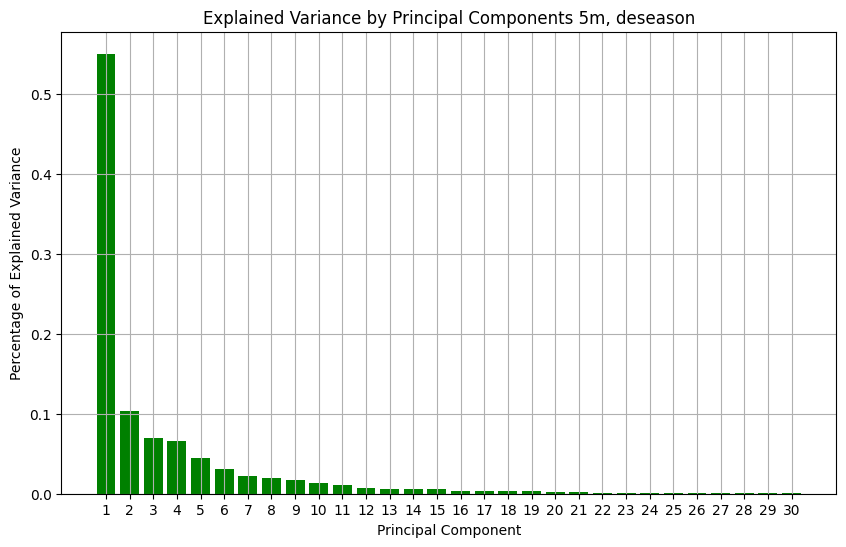

In [8]:
pca = PCA()
pca.fit(deseason)
variance_ratios = pca.explained_variance_ratio_
## Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(variance_ratios)+1), variance_ratios, color='g')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title(f'Explained Variance by Principal Components {freq}m, deseason')
plt.xticks(range(1, len(variance_ratios)+1))  
plt.grid(True)
plt.show()

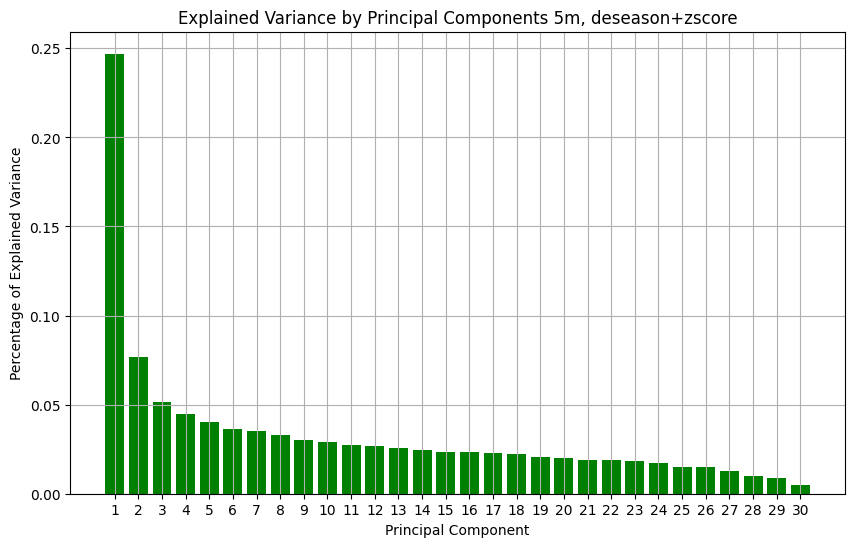

In [9]:
pca.fit(deseason_zscore)
variance_ratios = pca.explained_variance_ratio_
## Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(variance_ratios)+1), variance_ratios, color='g')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title(f'Explained Variance by Principal Components {freq}m, deseason+zscore')
plt.xticks(range(1, len(variance_ratios)+1))  
plt.grid(True)
plt.show()

In [9]:
# def preprocess_spline(data, season='-mean', transform=False, method='mean', smoothing_factor=0.5):
#     df = copy.deepcopy(data)
#     data['hms'] = data.index.strftime('%H%M%S')
#     unique_times = sorted(data.hms.unique().tolist())
#     smoothed_values = []
#     for col in df.columns:
#         if 'mean' in season:
#             raw_values = [np.nanmean(data[data.hms == hms][col].values) for hms in unique_times]
#         elif 'median' in season:
#             raw_values = [np.nanmedian(data[data.hms == hms][col].values) for hms in unique_times]
#         else:
#             raise ValueError('Deseason method must be either "mean" or "median"')
#         spline = UnivariateSpline(range(len(unique_times)), raw_values, s=smoothing_factor * len(unique_times))
#         smoothed_value = spline(range(len(unique_times)))
#         smoothed_values.append(smoothed_value)
#     smoothed_values = np.array(smoothed_values).T
#     smoothed_values = np.tile(smoothed_values, (int(len(df) / len(smoothed_values)), 1))
#     if season[0] == '-':
#         df.values[:] = df.values - smoothed_values
#     else:
#         df.values[:] = df.values / smoothed_values
#     # Normalization
#     if transform:
#         if method == 'mean':
#             df.values[:] = (df.values - np.nanmean(df.values, axis=0)) / np.nanstd(df.values, axis=0)
#         elif method == 'median':
#             df.values[:] = (df.values - np.nanmedian(df.values, axis=0)) / np.nanstd(df.values, axis=0)
#         else:
#             raise ValueError('Transform method must be either "mean" or "median"')
#     df.fillna(method='ffill', inplace=True)
#     return df

# def report_statistics(data, percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
#     stats = {
#         'mean': data.mean(),
#         'median': data.median(),
#         'std_dev': data.std(),
#         'percentiles': data.quantile(percentiles).to_dict()
#     }
#     print("Statistics:")
#     print(f"Mean: {stats['mean']}\nMedian: {stats['median']}\nStandard Deviation: {stats['std_dev']}")
#     print("Percentiles:")
#     for p, value in stats['percentiles'].items():
#         print(f"{int(p*100)}th percentile: {value}")
    
#     return stats

# def plot_histograms(df, bins=30):
#     num_stocks = len(df.columns) # Limit to 30 stocks for plotting
#     fig, axes = plt.subplots(int(num_stocks/5), 5, figsize=(20, 24))
#     for i, stock in enumerate(df.columns[:num_stocks]):
#         ax = axes[i // 5, i % 5]  # Determine subplot position
#         # Use pandas Series methods for plotting
#         df[stock].dropna().plot(kind='hist', bins=bins, alpha=0.6, color='b', density=True, ax=ax)
#         df[stock].dropna().plot(kind='density', color='r', ax=ax)
#         ax.set_title(f'Histogram & Density for {stock}')
#         ax.set_xlabel('Volume')
#         ax.set_ylabel('Density')
#     plt.tight_layout()
#     plt.show()

# def plot_acf(df, lags=30):
#     num_stocks = min(30, len(df.columns))  # Limit to 30 stocks for plotting
#     fig, axes = plt.subplots(6, 5, figsize=(20, 24))  # 6 rows, 5 columns
#     for i, stock in enumerate(df.columns[:num_stocks]):
#         ax = axes[i // 5, i % 5]  # Determine subplot position
#         acf_values = [df[stock].autocorr(lag) for lag in range(1, lags + 1)]
#         ax.stem(range(1, lags + 1), acf_values, basefmt=" ", use_line_collection=True)
#         ax.set_title(f'ACF for {stock}')
#         ax.set_xlabel('Lags')
#         ax.set_ylabel('Autocorrelation')
#         ax.set_ylim([0, 1])  # Set y-axis limit to [0, 1]
#     plt.tight_layout()
#     plt.show()

# def plot_ccf(df, ref_stock='SPY', lags=30):
#     num_stocks = min(30, len(df.columns))  # Limit to 30 stocks for plotting
#     fig, axes = plt.subplots(6, 5, figsize=(20, 24))  # 6 rows, 5 columns
#     for i, stock in enumerate(df.columns[:num_stocks]):
#         ax = axes[i // 5, i % 5]  # Determine subplot position
#         if ref_stock in df.columns:
#             ccf_values = [df[stock].corr(df[ref_stock].shift(lag)) for lag in range(1, lags + 1)]
#             ax.stem(range(1, lags + 1), ccf_values, basefmt=" ", use_line_collection=True)
#             ax.set_title(f'CCF between {stock} and {ref_stock}')
#             ax.set_xlabel('Lags')
#             ax.set_ylabel('Cross-Correlation')
#             ax.set_ylim([0, 1])  # Set y-axis limit to [0, 1]
#         else:
#             ax.text(0.5, 0.5, 'Reference stock not found', ha='center', va='center')
#             ax.set_title(f'CCF between {stock} and {ref_stock}')
#             ax.set_ylim([0, 1])  # Set y-axis limit to [0, 1]
#     plt.tight_layout()
#     plt.show()

In [37]:
from importlib import reload
reload(dataPKG)
dataPKG.fetch_data_stock('AAPL', bgn_date, end_date, '1', ['trade_volume'])

,time,trade_count_x,trade_volume_x,trade_first_x,trade_last_x,trade_high_x,trade_low_x,bid_price_x,bid_size_x,ask_price_x,...,trade_low_y,bid_price_y,bid_size_y,ask_price_y,ask_size_y,hid_vol_y,buy_vol_y,sell_vol_y,unsided_vol_y,vwap_y
0,2022-01-03 09:31:00,4258.0,286592.0,177.68,178.060,178.20,177.71,178.06,299.0,178.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 09:32:00,4010.0,291514.0,177.68,178.840,179.03,177.88,178.84,200.0,178.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03 09:33:00,3014.0,201730.0,177.68,178.880,179.31,178.80,178.86,902.0,178.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-03 09:34:00,2310.0,162776.0,177.68,179.022,179.11,178.73,179.02,900.0,179.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-03 09:35:00,1947.0,147119.0,177.68,178.950,179.24,178.90,178.95,700.0,178.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22615,2022-03-31 15:56:00,11046.0,1018219.0,178.21,175.480,175.65,174.52,175.48,300.0,175.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22616,2022-03-31 15:57:00,7784.0,697046.0,178.21,175.280,175.49,175.10,175.26,943.0,175.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22617,2022-03-31 15:58:00,9221.0,822044.0,178.21,175.110,175.50,175.01,175.10,3480.0,175.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22618,2022-03-31 15:59:00,8262.0,734326.0,178.21,175.075,175.22,174.90,175.07,1463.0,175.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,time,trade_count_x,trade_volume_x,trade_first_x,trade_last_x,trade_high_x,trade_low_x,bid_price_x,bid_size_x,ask_price_x,...,trade_low_y,bid_price_y,bid_size_y,ask_price_y,ask_size_y,hid_vol_y,buy_vol_y,sell_vol_y,unsided_vol_y,vwap_y
385,155600,3257.0,303497.0,177.68,181.77,181.90,181.70,181.76,412.0,181.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
386,155700,1979.0,199256.0,177.68,181.93,181.94,181.71,181.93,27.0,181.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387,155800,1909.0,197795.0,177.68,181.91,181.95,181.88,181.91,600.0,181.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,155900,2749.0,297866.0,177.68,181.87,181.93,181.82,181.86,3843.0,181.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,160000,5773.0,810688.0,177.68,182.00,182.01,181.78,182.00,100.0,182.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
